# Time delay surface for the general lens

In this example, we make use of inheritance to use the methods defined in the past lesson for the PSIE lens also for other classes of the lens models. 

Here is how it works:

* we build a class called "general lens". In this class we put all the methods that should work with any lens, not just the PSIE
* we build a child class, called PSIE. The only method which is specific to this lens is the gravitational time delay.
* we can add any other class, for example one for numerically simulated lenses, which is also child of the general lens class.

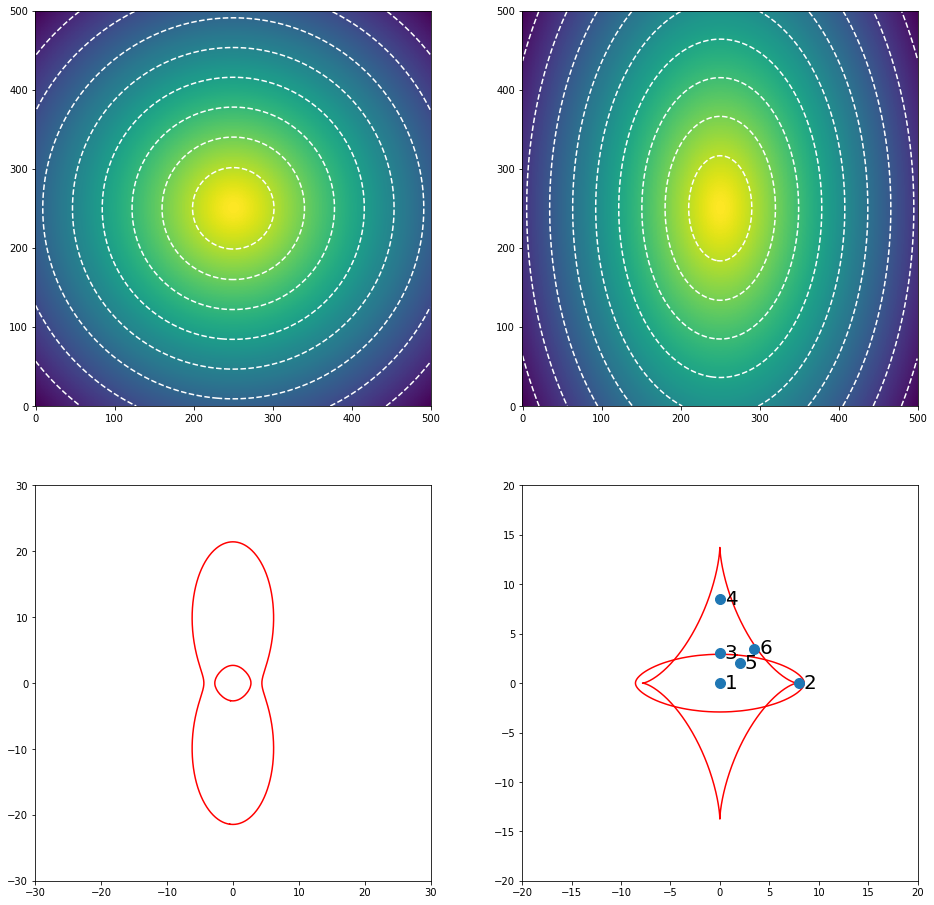

In [1]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 25}
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rc('font', **font)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.ndimage import map_coordinates
import pylab
import astropy.io.fits as pyfits
from scipy.ndimage import map_coordinates
import numpy.fft as fftengine


# the parent class
class gen_lens(object):
    def __init__(self):
        self.pot_exists=False
    
    # geometrical time delay
    def t_geom_surf(self,size=40.0, npix=500.0, beta=None):
        pixel=size/(npix-1) 
        x = np.arange(0, npix, 1, float)*pixel
        y = x[:,np.newaxis]
        if beta is None:
            x0 = y0 = npix / 2*pixel
        else:
            x0 = beta[0]+npix/2*pixel
            y0 = beta[1]+npix/2*pixel
        
        return 0.5*((x-x0)*(x-x0)+(y-y0)*(y-y0))
    
    # total time delay
    def t_delay_surf(self,size=40.0,npix=500,beta=None):
        t_grav=self.t_grav_surf(size,npix)
        t_geom=self.t_geom_surf(size,npix,beta)
        td=(t_grav+t_geom)
        return(t_grav+t_geom)
    
    # convergence 
    def convergence(self):
        if (self.pot_exists):
            kappa=0.5*(self.a11+self.a22)
        else:
            print ("The lens potential is not initialized yet")
            
        return(kappa)
    
    #shear
    def shear(self):
        if (self.pot_exists):
            g1=0.5*(self.a11-self.a22)
            g2=self.a12
        else:
            print ("The lens potential is not initialized yet")
        return(g1,g2)
    
    # determinant of the Jacobian matrix
    def detA(self):
        if (self.pot_exists):
            deta=(1.0-self.a11)*(1.0-self.a22)-self.a12*self.a21
        else:
            print ("The lens potential is not initialized yet")
        return(deta)
    
    # critical lines overlaid to the map of detA, returns a set of contour objects
    def crit_lines(self,ax=None,show=True):
        if (ax==None): 
            print ("specify the axes to display the critical lines")
        else:
            deta=self.detA()
            ax.imshow(deta,origin='lower')
            cs=ax.contour(deta,levels=[0.0],colors='white')
            if show==False:
                ax.clear()
        return(cs)
    
    # plot of the critical lines
    def clines(self,ax=None):
        cs=self.crit_lines(ax=ax,show=False)
        contour=cs.collections[0]
        p=contour.get_paths()
        sizevs=np.empty(len(p),dtype=int)
        
        no=self.size/(self.npix-1)
        # if we found any contour, then we proceed
        if (sizevs.size > 0):
            for j in range(len(p)):
                # for each path, we create two vectors containing 
                #the x1 and x2 coordinates of the vertices
                vs = contour.get_paths()[j].vertices 
                sizevs[j]=len(vs)
                x1=[]
                x2=[]
                for i in range(len(vs)):
                    xx1,xx2=vs[i]
                    x1.append(float(xx1))
                    x2.append(float(xx2))
        
                # plot the results!
                ax.plot((np.array(x1)-self.npix/2.)*no,
                        (np.array(x2)-self.npix/2.)*no,'-',color='red')
    
    # plot of the caustics
    def caustics(self,ax=None):
        cs=self.crit_lines(ax=ax,show=False)
        contour=cs.collections[0]
        p=contour.get_paths() # p contains the paths of each individual 
                              # critical line
        sizevs=np.empty(len(p),dtype=int)
        
        # if we found any contour, then we proceed
        if (sizevs.size > 0):
            for j in range(len(p)):
                # for each path, we create two vectors containing 
                # the x1 and x2 coordinates of the vertices
                vs = contour.get_paths()[j].vertices 
                sizevs[j]=len(vs)
                x1=[]
                x2=[]
                for i in range(len(vs)):
                    xx1,xx2=vs[i]
                    x1.append(float(xx1))
                    x2.append(float(xx2))
                # these are the points we want to map back on the source plane. 
                # To do that we need to evaluate the deflection angle at their positions
                # using scipy.ndimage.interpolate.map_coordinates we perform a bi-linear interpolation
                a_1=map_coordinates(self.a1, [[x2],[x1]],order=1)
                a_2=map_coordinates(self.a2, [[x2],[x1]],order=1)
        
                # now we can make the mapping using the lens equation:
                no=np.float(self.size)/(self.npix-1)
                y1=(x1-a_1[0]-self.npix/2.)*no
                y2=(x2-a_2[0]-self.npix/2.)*no
        
                # plot the results!
                #ax.plot((np.array(x1)-npix/2.)*no*f,(np.array(x2)-npix/2.)*no*f,'-')
                ax.plot(y1,y2,'-',color='red')
                
    # display the time delay surface
    def show_surface(self,surf0,ax=None,minx=-25,miny=-25,vmax=2,rstride=1,
                     cstride=1,cmap=plt.get_cmap('Paired'),
                     linewidth=0, antialiased=False,alpha=0.2,fontsize=20,offz=0.0):
        
        surf=surf0+offz
        if ax==None:
            print ("specify the axes with 3d projection to display the surface")
        else:
            xa=np.arange(-self.npix/2, self.npix/2, 1)
            ya=np.arange(-self.npix/2, self.npix/2, 1)
        # I will show the contours levels projected in the x-y plane
            levels=np.linspace(np.amin(surf),np.amax(surf),40)

            minx=minx
            maxx=-minx

            miny=miny
            maxy=-miny

            pixel_size=self.size/(self.npix-1)
            X, Y = np.meshgrid(xa*pixel_size, ya*pixel_size)
            ax.plot_surface(X,Y,surf,vmax=vmax,rstride=rstride, cstride=cstride, cmap=cmap,
                       linewidth=linewidth, antialiased=antialiased,alpha=alpha)

            cset = ax.contour(X, Y, surf, zdir='z', 
                               offset=np.amin(surf)-20.0, cmap=cmap,levels=levels)
            deta=self.detA()
            cset = ax.contour(X, Y, deta, zdir='z', 
                               offset=np.amin(surf)-20.0, colors='black',levels=[0])            
            cset = ax.contour(X, Y, surf, zdir='x', offset=minx, cmap=cmap,levels=[0])
            cset = ax.contour(X, Y, surf, zdir='y', offset=maxy, cmap=cmap,levels=[0])
            ax.set_xlim3d(minx, maxx)
            ax.set_ylim3d(miny, maxy)
            ax.set_zlim3d(np.amin(surf)-20.0, 10)
            ax.set_xlabel(r'$\theta_1$',fontsize=fontsize)
            ax.set_ylabel(r'$\theta_2$',fontsize=fontsize)
            ax.set_aspect('equal')            

    # display the time delay contours
    def show_contours(self,surf0,ax=None,minx=-25,miny=-25,cmap=plt.get_cmap('Paired'),
                     linewidth=0,fontsize=20,nlevels=40,levmax=100,offz=0.0):
        if ax==None:
            print ("specify the axes to display the contours")
        else:
            minx=minx
            maxx=-minx
            miny=miny
            maxy=-miny
            #surf=surf0+offz
            surf=surf0-np.min(surf0)
            levels=np.linspace(np.min(surf),levmax,nlevels)
            print np.min(levels),np.max(levels)
            #ax.imshow(surf,extent=[-self.size/2,self.size/2,-self.size/2,self.size/2])
            ax.contour(surf, cmap=cmap,levels=levels,extent=[-self.size/2,self.size/2,-self.size/2,self.size/2])
            ax.set_xlim(minx, maxx)
            ax.set_ylim(miny, maxy)
            ax.set_xlabel(r'$\theta_1$',fontsize=fontsize)
            ax.set_ylabel(r'$\theta_2$',fontsize=fontsize)
            ax.set_aspect('equal')    

# child class PSIE
class psie(gen_lens):
    def __init__(self,theta_c=0.0,ell=0.0,norm=1.0):
        self.theta_c=theta_c
        self.ell=ell
        self.norm=norm
        
    # gravitational time delay for the PSIE lens   
    def t_grav_surf(self,size=40.0,npix=500.0):
        pixel=size/(npix-1)
        x = np.arange(0, npix, 1, float)
        y = x[:,np.newaxis]
        x0 = y0 = npix / 2
        self.size=size
        self.npix=npix
        no=(self.size/(self.npix-1))**2
        self.pot_exists=True
        pot=np.sqrt(((x-x0)*pixel)**2/(1-self.ell)
                         +((y-y0)*pixel)**2*(1-self.ell)
                         +self.theta_c**2)*self.norm
        self.pot=pot/(self.size/self.npix)**2
        self.a2,self.a1=np.gradient(self.pot)
        self.a12,self.a11=np.gradient(self.a1)
        self.a22,self.a21=np.gradient(self.a2)
        return -pot

# child class deflector  
class deflector(gen_lens):

    
    # initialize the deflector using a surface density (covergence) map
    # the boolean variable pad indicates whether zero-padding is used or not
    def __init__(self,filekappa,pad=False):
        kappa,header=pyfits.getdata(filekappa,header=True)
        self.pixel_scale=header['CDELT2']*3600.0
        self.kappa=kappa
        self.nx=kappa.shape[0]
        self.ny=kappa.shape[1]
        self.pad=pad
        if (pad):
            self.kpad()
        
    # performs zero-padding
    def kpad(self):
        # add zeros around the original array
        def padwithzeros(vector, pad_width, iaxis, kwargs):
            vector[:pad_width[0]] = 0
            vector[-pad_width[1]:] = 0
            return vector
        # use the pad method from numpy.lib to add zeros (padwithzeros) in a
        # frame with thickness self.kappa.shape[0]
        self.kappa=np.lib.pad(self.kappa, self.kappa.shape[0], 
                              padwithzeros)
        
    # calculate the potential by solving the poisson equation
    def potential(self):
        # define an array of wavenumbers (two components k1,k2)
        k = np.array(np.meshgrid(fftengine.fftfreq(self.kappa.shape[0])\
                                 ,fftengine.fftfreq(self.kappa.shape[1])))
        pix=1 # pixel scale (now using pixel units)
        #Compute Laplace operator in Fourier space = -4*pi*k^2
        kk = k[0]**2 + k[1]**2
        kk[0,0] = 1.0
        #FFT of the convergence
        kappa_ft = fftengine.fftn(self.kappa)
        #compute the FT of the potential
        kappa_ft *= - pix**2 / (kk * (2.0*np.pi**2))
        kappa_ft[0,0] = 0.0
        potential=fftengine.ifftn(kappa_ft) #units should be rad**2
        return potential.real
    
    # returns the map of the gravitational time delay
    def t_grav_surf(self,size=40.0,npix=500.0):
        print 'computing tgrav'
        self.size=size
        self.npix=npix
        no=np.float(self.size)/(self.npix-1)
        x_ = np.linspace(0,npix-1,npix)
        y_ = np.linspace(0,npix-1,npix)
        x,y=np.meshgrid(x_,y_)
        potential=self.potential()
        x0 = y0 = potential.shape[0] / 2*self.pixel_scale-size/2.0
        x=(x0+x*no)/self.pixel_scale
        y=(y0+y*no)/self.pixel_scale
        self.pot_exists=True
        pot=map_coordinates(potential,[[y],[x]],order=1).reshape(int(npix),int(npix))
        self.pot=pot*self.pixel_scale**2/no/no
        self.a2,self.a1=np.gradient(self.pot)
        self.a12,self.a11=np.gradient(self.a1)
        self.a22,self.a21=np.gradient(self.a2)
        return -pot*self.pixel_scale**2#*no*no
    
%matplotlib inline

size=60.
npix=500.
cl=psie(theta_c=2.0,norm=10.0)
el=psie(ell=0.4,theta_c=2.0,norm=10)

t_grav_surf0=cl.t_grav_surf(size,npix)
t_grav_surf=el.t_grav_surf(size,npix)

l0=np.linspace(t_grav_surf0.min(),t_grav_surf0.max(),10)

fig,ax=plt.subplots(2,2,figsize=(16,16))
ax[0,0].imshow(t_grav_surf0,origin='lower')
ax[0,1].imshow(t_grav_surf,origin='lower')
ax[0,0].contour(t_grav_surf0,levels=l0,colors='white')
ax[0,1].contour(t_grav_surf,levels=l0,colors='white')
el.clines(ax=ax[1,0])
el.caustics(ax=ax[1,1])
ax[1,0].set_xlim([-30,30])
ax[1,0].set_ylim([-30,30])
ax[1,1].set_xlim([-20,20])
ax[1,1].set_ylim([-20,20])

betax=[0,8,0,0,2,3.5]
betay=[0,0,3,8.5,2,3.5]
labels=['1','2','3','4','5','6']
ax[1,1].plot(betax,betay,'o',markersize=10)
for i, txt in enumerate(labels):
    ax[1,1].annotate(txt, (betax[i]+0.5,betay[i]-0.5),fontsize=20)

We can now try to generate the time delay surfaces of some sources using a PSIE lens. We should be able to reproduce the results from the last lesson:

<IPython.core.display.Javascript object>


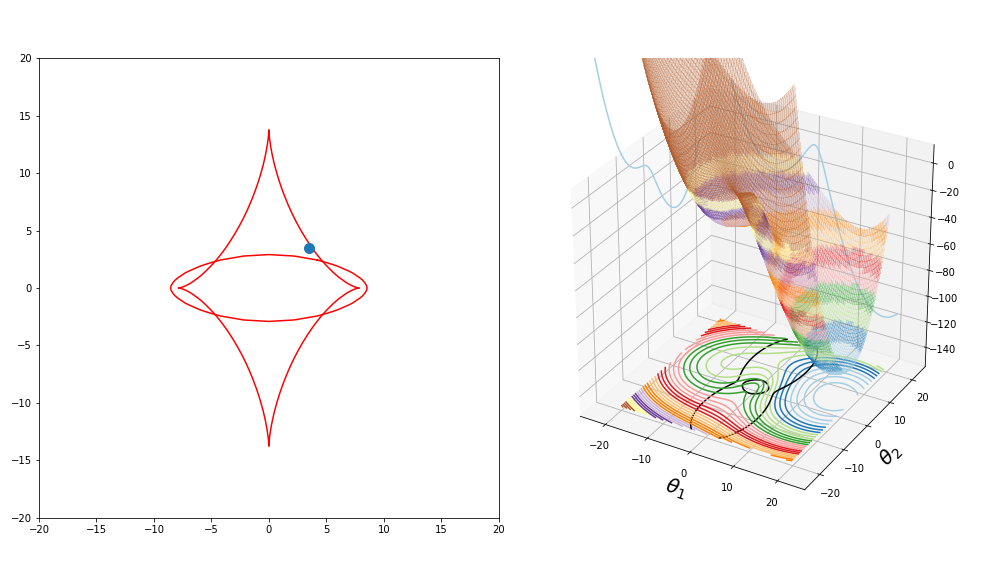

In [6]:
%matplotlib notebook

betax=[0,8,0,0,2,3.5]
betay=[0,0,3,8.5,2,3.5]

# source params
beta1=betax[5]#0.
beta2=betay[5]#0.
beta=[beta1,beta2]

# lens params
ell=0.4
theta_c=2.0

fig = plt.figure(figsize=(13.8,8))
ax=fig.add_subplot(121)
el=psie(ell=ell,theta_c=theta_c,norm=10)
el.t_grav_surf(size*1.2,250)
el.caustics(ax=ax)
ax.plot(beta[0],beta[1],'o',markersize=10)
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])
ax.set_aspect('equal')


ax3d = fig.add_subplot(122, projection='3d')

npix=100
size=40.0
el3d=psie(ell=ell,theta_c=theta_c,norm=10)
td3d=el3d.t_delay_surf(npix=npix,size=size,beta=beta)
el3d.show_surface(td3d,ax=ax3d)
fig.tight_layout()

Now we study the time-delay surface of a numerically simulated lens:

<IPython.core.display.Javascript object>


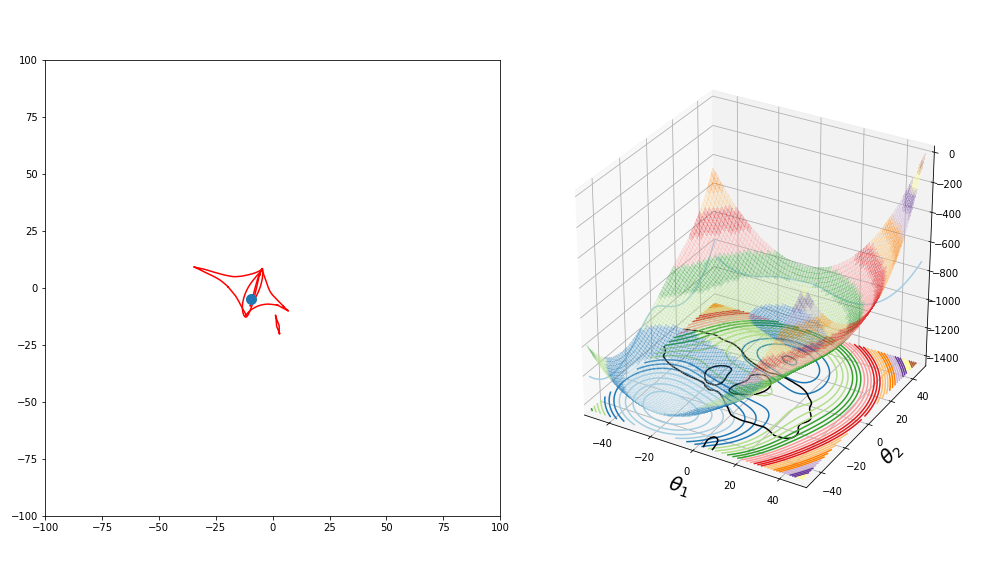

computing tgrav
computing tgrav


In [4]:
df=deflector('data/kappa_2.fits',True)
size=200.0
npix=500

%matplotlib notebook

beta=[-9.4,-4.8]

fig = plt.figure(figsize=(13.8,8))
ax=fig.add_subplot(121)
df.t_grav_surf(size,npix)
df.caustics(ax=ax)
ax.plot(beta[0],beta[1],'o',markersize=10)
ax.set_xlim([-100,100])
ax.set_ylim([-100,100])
ax.set_aspect('equal')


ax3d = fig.add_subplot(122, projection='3d')

npix=80
size=100.0
df3d=deflector('data/kappa_2.fits',True)
td3d=df3d.t_delay_surf(npix=npix,size=size,beta=beta)
df3d.show_surface(td3d,ax=ax3d,minx=-50,miny=-50,offz=-np.max(td3d))
fig.tight_layout()

<IPython.core.display.Javascript object>


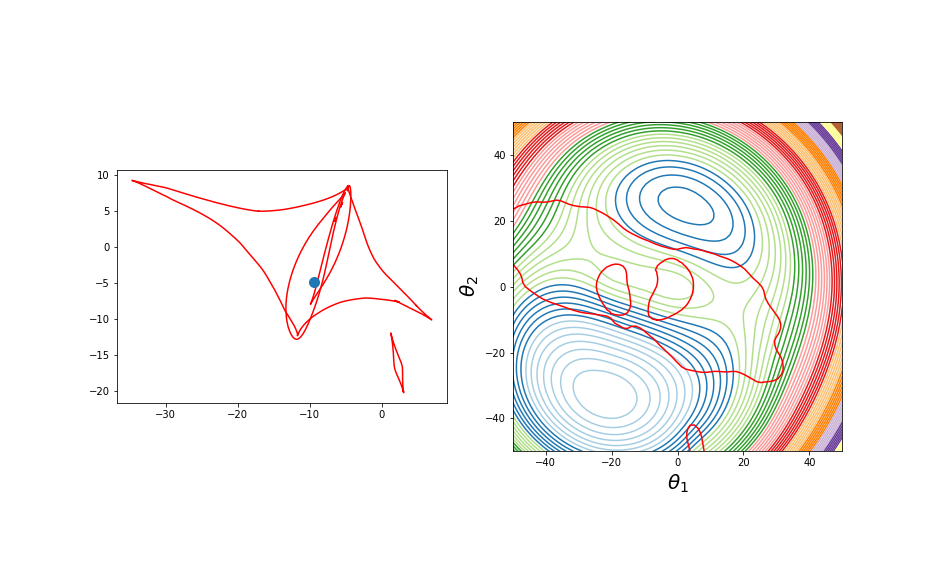

computing tgrav
0.0 1500.0


In [5]:
%matplotlib notebook
fig,ax=plt.subplots(1,2,figsize=(13,8))
df.caustics(ax=ax[0])
ax[0].plot(beta[0],beta[1],'o',markersize=10)
td=df.t_delay_surf(npix=npix,size=size,beta=beta)
df.clines(ax=ax[1])
df.show_contours(td,ax=ax[1],minx=-50,miny=-50,nlevels=80,levmax=1500)